# Table of contents

[<h3>1. Load and transform the dataset</h3>](#1)

[<h3>2. Load the Images with a generator</h3>](#2)

[<h3>3. Test 27 canned architectures with pre-trained weights</h3>](#3)

[<h3>4. Train the model MobileNetV2</h3>](#4)

[<h3>5. Visualize the result</h3>](#5)

[<h3>6. Class activation heatmap for image classification</h3>](#6)

[<h3>7. Using a two-class model (DR and No_DR)</h3>](#7)

## About the Data
The images consist of gaussian filtered retina scan images to detect diabetic retinopathy. The original dataset is available at APTOS 2019 Blindness Detection. These images are resized into 224x224 pixels so that they can be readily used with many pre-trained deep learning models.

All of the images are already saved into their respective folders according to the severity/stage of diabetic retinopathy using the train.csv file provided. You will find five directories with the respective images:

- 0 - No_DR
- 1 - Mild
- 2 - Moderate
- 3 - Severe
- 4 - Proliferate_DR

The dataset contains an export.pkl file which is a ResNet34 model trained on the dataset for 20 epochs using the FastAI library.

## Acknowledgements
[APTOS 2019 Blindness Detection](https://www.kaggle.com/c/aptos2019-blindness-detection/overview)

# 1. Load and transform the dataset<a class="anchor" id="1"></a>

In [2]:
import numpy as np
import pandas as pd
from pathlib import Path
import os.path
import matplotlib.pyplot as plt
from IPython.display import Image, display, Markdown
import matplotlib.cm as cm
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
import tensorflow as tf
from time import perf_counter
import seaborn as sns

def printmd(string):
    # Print with Markdowns    
    display(Markdown(string))

In [3]:
image_dir = Path('/Users/apple/Downloads/SDP/images')

# Get filepaths and labels
filepaths = list(image_dir.glob(r'**/*.png'))
labels = list(map(lambda x: os.path.split(os.path.split(x)[0])[1], filepaths))

In [4]:
import ssl

ssl._create_default_https_context = ssl._create_unverified_context

In [5]:
filepaths = pd.Series(filepaths, name='Filepath').astype(str)
labels = pd.Series(labels, name='Label')

# Concatenate filepaths and labels
image_df = pd.concat([filepaths, labels], axis=1)

# Shuffle the DataFrame and reset index
image_df = image_df.sample(frac=1).reset_index(drop = True)

# Show the result
image_df

,Filepath,Label
0,/Users/apple/Downloads/SDP/images/No_DR/cbe633...,No_DR
1,/Users/apple/Downloads/SDP/images/Mild/f481f76...,Mild
2,/Users/apple/Downloads/SDP/images/No_DR/41345c...,No_DR
3,/Users/apple/Downloads/SDP/images/Proliferate_...,Proliferate_DR
4,/Users/apple/Downloads/SDP/images/No_DR/3f6bcc...,No_DR
...,...,...
3657,/Users/apple/Downloads/SDP/images/No_DR/24de56...,No_DR
3658,/Users/apple/Downloads/SDP/images/Moderate/fa7...,Moderate
3659,/Users/apple/Downloads/SDP/images/Moderate/012...,Moderate
3660,/Users/apple/Downloads/SDP/images/No_DR/3f44d7...,No_DR


## Visualization

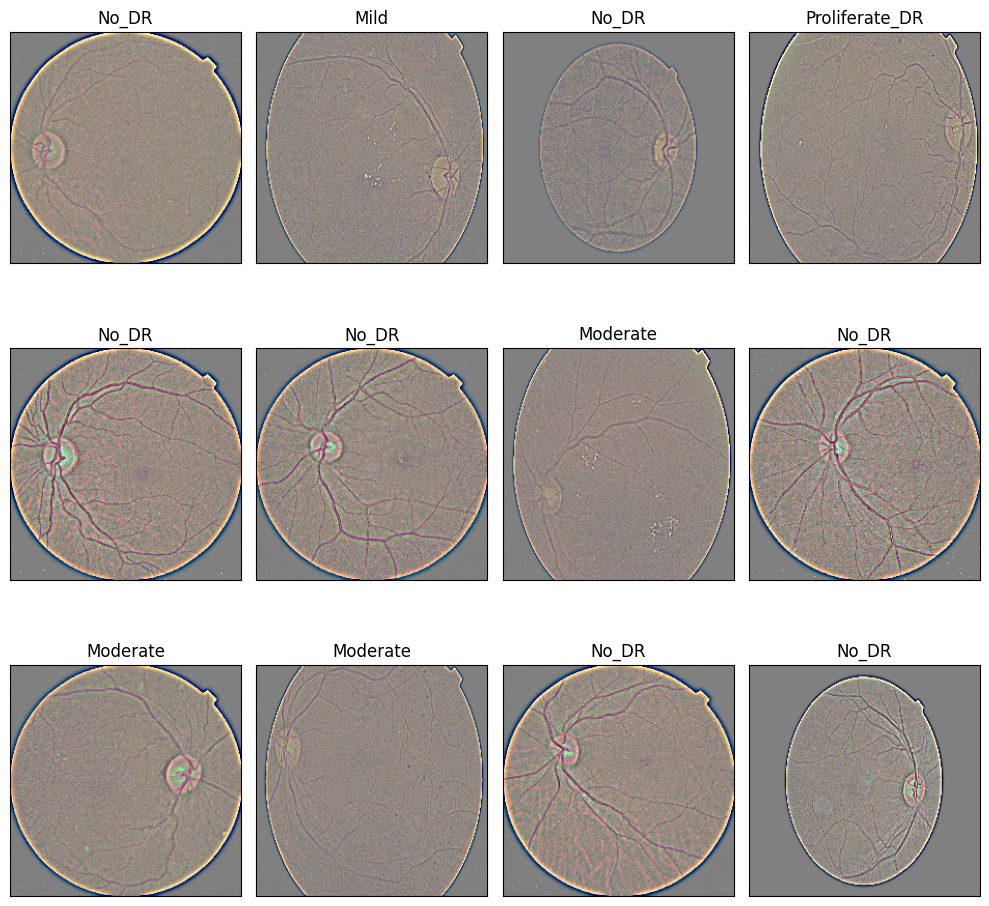

In [6]:
# Display some pictures of the dataset with their labels
fig, axes = plt.subplots(nrows=3, ncols=4, figsize=(10, 10),
                        subplot_kw={'xticks': [], 'yticks': []})

for i, ax in enumerate(axes.flat):
    ax.imshow(plt.imread(image_df.Filepath[i]))
    ax.set_title(image_df.Label[i])
plt.tight_layout()
plt.show()

In [7]:
import warnings
warnings.filterwarnings('ignore')

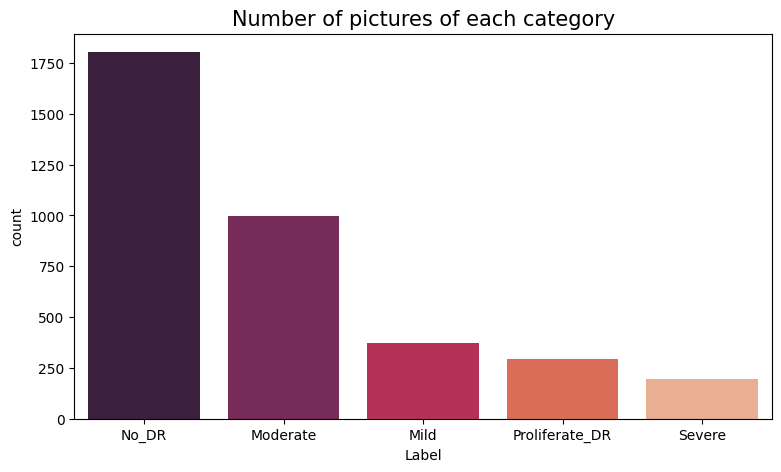

In [8]:
# Display the number of pictures of each category
vc = image_df['Label'].value_counts()
plt.figure(figsize=(9,5))
sns.barplot(x = vc.index, y = vc, palette = "rocket")
plt.title("Number of pictures of each category", fontsize = 15)
plt.show()

In [9]:
pip install plotly

Note: you may need to restart the kernel to use updated packages.


In [10]:
import plotly
import plotly.express as px

# 2. Load the Images with a generator<a class="anchor" id="2"></a>

In [11]:
def create_gen():
    # Load the Images with a generator and Data Augmentation
    train_generator = tf.keras.preprocessing.image.ImageDataGenerator(
        preprocessing_function=tf.keras.applications.mobilenet_v2.preprocess_input,
        validation_split=0.1
    )

    test_generator = tf.keras.preprocessing.image.ImageDataGenerator(
        preprocessing_function=tf.keras.applications.mobilenet_v2.preprocess_input
    )

    train_images = train_generator.flow_from_dataframe(
        dataframe=train_df,
        x_col='Filepath',
        y_col='Label',
        target_size=(224, 224),
        color_mode='rgb',
        class_mode='categorical',
        batch_size=32,
        shuffle=True,
        seed=0,
        subset='training',
        rotation_range=30, # Uncomment to use data augmentation
        zoom_range=0.15,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.15,
        horizontal_flip=True,
        fill_mode="nearest"
    )

    val_images = train_generator.flow_from_dataframe(
        dataframe=train_df,
        x_col='Filepath',
        y_col='Label',
        target_size=(224, 224),
        color_mode='rgb',
        class_mode='categorical',
        batch_size=32,
        shuffle=True,
        seed=0,
        subset='validation',
        rotation_range=30, # Uncomment to use data augmentation
        zoom_range=0.15,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.15,
        horizontal_flip=True,
        fill_mode="nearest"
    )

    test_images = test_generator.flow_from_dataframe(
        dataframe=test_df,
        x_col='Filepath',
        y_col='Label',
        target_size=(224, 224),
        color_mode='rgb',
        class_mode='categorical',
        batch_size=32,
        shuffle=False
    )
    
    return train_generator,test_generator,train_images,val_images,test_images

# 3. Test 27 canned architectures with pre-trained weights<a class="anchor" id="3"></a>

More info about the architectures under: [Module: tf.keras.applications](https://www.tensorflow.org/api_docs/python/tf/keras/applications?hl=enhttps://www.tensorflow.org/api_docs/python/tf/keras/applications?hl=en)

In [12]:
def get_model(model):
# Load the pretained model
    kwargs =    {'input_shape':(224, 224, 3),
                'include_top':False,
                'weights':'imagenet',
                'pooling':'avg'}
    
    pretrained_model = model(**kwargs)
    pretrained_model.trainable = False
    
    inputs = pretrained_model.input

    x = tf.keras.layers.Dense(128, activation='relu')(pretrained_model.output)
    x = tf.keras.layers.Dense(128, activation='relu')(x)

    outputs = tf.keras.layers.Dense(5, activation='softmax')(x)

    model = tf.keras.Model(inputs=inputs, outputs=outputs)

    model.compile(
        optimizer='adam',
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )
    
    return model

In [13]:
# Separate in train and test data
train_df, test_df = train_test_split(image_df, train_size=0.9, shuffle=True, random_state=1)

In [15]:
test_df

,Filepath,Label
2830,/Users/apple/Downloads/SDP/images/Moderate/ff0...,Moderate
1247,/Users/apple/Downloads/SDP/images/Moderate/3cd...,Moderate
102,/Users/apple/Downloads/SDP/images/Mild/5821159...,Mild
2687,/Users/apple/Downloads/SDP/images/Severe/dd3da...,Severe
2868,/Users/apple/Downloads/SDP/images/Severe/38055...,Severe
...,...,...
3339,/Users/apple/Downloads/SDP/images/Moderate/310...,Moderate
2984,/Users/apple/Downloads/SDP/images/No_DR/84b88e...,No_DR
3438,/Users/apple/Downloads/SDP/images/No_DR/e582e5...,No_DR
3651,/Users/apple/Downloads/SDP/images/No_DR/3232b3...,No_DR


In [14]:
# Dictionary with the models
models = {
    "DenseNet121": {"model":tf.keras.applications.DenseNet121, "perf":0},
    "MobileNetV2": {"model":tf.keras.applications.MobileNetV2, "perf":0},
    "DenseNet169": {"model":tf.keras.applications.DenseNet169, "perf":0},
    "DenseNet201": {"model":tf.keras.applications.DenseNet201, "perf":0},
    "EfficientNetB0": {"model":tf.keras.applications.EfficientNetB0, "perf":0},
    "EfficientNetB1": {"model":tf.keras.applications.EfficientNetB1, "perf":0},
    "EfficientNetB2": {"model":tf.keras.applications.EfficientNetB2, "perf":0},
    "EfficientNetB3": {"model":tf.keras.applications.EfficientNetB3, "perf":0},
    "EfficientNetB4": {"model":tf.keras.applications.EfficientNetB4, "perf":0},
    "EfficientNetB5": {"model":tf.keras.applications.EfficientNetB4, "perf":0},
    "EfficientNetB6": {"model":tf.keras.applications.EfficientNetB4, "perf":0},
    "EfficientNetB7": {"model":tf.keras.applications.EfficientNetB4, "perf":0},
    "InceptionResNetV2": {"model":tf.keras.applications.InceptionResNetV2, "perf":0},
    "InceptionV3": {"model":tf.keras.applications.InceptionV3, "perf":0},
    "MobileNet": {"model":tf.keras.applications.MobileNet, "perf":0},
    "MobileNetV2": {"model":tf.keras.applications.MobileNetV2, "perf":0},
    "MobileNetV3Large": {"model":tf.keras.applications.MobileNetV3Large, "perf":0},
    "MobileNetV3Small": {"model":tf.keras.applications.MobileNetV3Small, "perf":0},
    "NASNetMobile": {"model":tf.keras.applications.NASNetMobile, "perf":0},
    "ResNet101": {"model":tf.keras.applications.ResNet101, "perf":0},
    "ResNet101V2": {"model":tf.keras.applications.ResNet101V2, "perf":0},
    "ResNet152": {"model":tf.keras.applications.ResNet152, "perf":0},
    "ResNet152V2": {"model":tf.keras.applications.ResNet152V2, "perf":0},
    "ResNet50": {"model":tf.keras.applications.ResNet50, "perf":0},
    "ResNet50V2": {"model":tf.keras.applications.ResNet50V2, "perf":0},
    "VGG16": {"model":tf.keras.applications.VGG16, "perf":0},
    "VGG19": {"model":tf.keras.applications.VGG19, "perf":0},
    "Xception": {"model":tf.keras.applications.Xception, "perf":0}
}

# Create the generators
train_generator,test_generator,train_images,val_images,test_images=create_gen()
print('\n')

# Fit the models
for name, model in models.items():
    
    # Get the model
    m = get_model(model['model'])
    models[name]['model'] = m
    
    start = perf_counter()
    
    # Fit the model
    history = m.fit(train_images,validation_data=val_images,epochs=1,verbose=1)
    
    # Sav the duration, the train_accuracy and the val_accuracy
    duration = perf_counter() - start
    duration = round(duration,2)
    models[name]['perf'] = duration
    print(f"{name:20} trained in {duration} sec")
    
    val_acc = history.history['val_accuracy']
    models[name]['val_acc'] = [round(v,4) for v in val_acc]
    
    train_acc = history.history['accuracy']
    models[name]['train_accuracy'] = [round(v,4) for v in train_acc]

Found 2966 validated image filenames belonging to 5 classes.
Found 329 validated image filenames belonging to 5 classes.
Found 367 validated image filenames belonging to 5 classes.


 9/93 ━━━━━━━━━━━━━━━━━━━━ 1:19 949ms/step - accuracy: 0.3875 - loss: 1.5086

KeyboardInterrupt: 

In [ ]:
# Create a DataFrame with the results
models_result = []

for name, v in models.items():
    models_result.append([ name, 
                          models[name]['train_accuracy'][-1],
                          models[name]['val_acc'][-1], 
                          models[name]['perf']])
    
df_results = pd.DataFrame(models_result, 
                          columns = ['model','train_accuracy','val_accuracy','Training time (sec)'])
df_results.sort_values(by='val_accuracy', ascending=False, inplace=True)
df_results.reset_index(inplace=True,drop=True)
df_results

In [ ]:
plt.figure(figsize = (15,5))
sns.barplot(x = 'model', y = 'train_accuracy', data = df_results)
plt.title('Accuracy on the Training Set (after 1 epoch)', fontsize = 15)
plt.ylim(0,1)
plt.xticks(rotation=90)
plt.show()

In [ ]:
plt.figure(figsize = (15,5))
sns.barplot(x = 'model', y = 'val_accuracy', data = df_results)
plt.title('Accuracy on the Validation Set (after 1 epoch)', fontsize = 15)
plt.ylim(0,1)
plt.xticks(rotation=90)
plt.show()

In [ ]:
plt.figure(figsize = (15,5))
sns.barplot(x = 'model', y = 'Training time (sec)', data = df_results)
plt.title('Training time for each model in sec', fontsize = 15)
plt.xticks(rotation=90)
plt.show()

# 4. Train the model MobileNetV2<a class="anchor" id="4"></a>

In [ ]:
# Load the pretained model
pretrained_model = tf.keras.applications.MobileNetV2(
    input_shape=(224, 224, 3),
    include_top=False,
    weights='imagenet',
    pooling='avg'
)

pretrained_model.trainable = False

In [ ]:
inputs = pretrained_model.input

x = tf.keras.layers.Dense(128, activation='relu')(pretrained_model.output)
x = tf.keras.layers.Dense(128, activation='relu')(x)

outputs = tf.keras.layers.Dense(5, activation='softmax')(x)

model = tf.keras.Model(inputs=inputs, outputs=outputs)

model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

history = model.fit(
    train_images,
    validation_data=val_images,
    batch_size = 32,
    epochs=10,
    callbacks=[
        tf.keras.callbacks.EarlyStopping(
            monitor='val_loss',
            patience=2,
            restore_best_weights=True
        )
    ]
)

In [ ]:
pd.DataFrame(history.history)[['accuracy','val_accuracy']].plot()
plt.title("Accuracy")
plt.show()

In [ ]:
pd.DataFrame(history.history)[['loss','val_loss']].plot()
plt.title("Loss")
plt.show()

# 5. Visualize the result<a class="anchor" id="5"></a>

In [ ]:
results = model.evaluate(test_images, verbose=0)

In [ ]:
printmd(" ## Test Loss: {:.5f}".format(results[0]))
printmd("## Accuracy on the test set: {:.2f}%".format(results[1] * 100))

In [ ]:
# Predict the label of the test_images
pred = model.predict(test_images)
pred = np.argmax(pred,axis=1)

# Map the label
labels = (train_images.class_indices)
labels = dict((v,k) for k,v in labels.items())
pred = [labels[k] for k in pred]

# Display the result
print(f'The first 5 predictions: {pred[:5]}')

In [ ]:
from sklearn.metrics import classification_report
y_test = list(test_df.Label)
print(classification_report(y_test, pred))

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

cf_matrix = confusion_matrix(y_test, pred, normalize='true')
plt.figure(figsize = (10,6))
sns.heatmap(cf_matrix, annot=True, xticklabels = sorted(set(y_test)), yticklabels = sorted(set(y_test)))
plt.title('Normalized Confusion Matrix')
plt.show()

In [ ]:
# Display some pictures of the dataset with their labels and the predictions
fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(15, 15),
                        subplot_kw={'xticks': [], 'yticks': []})

for i, ax in enumerate(axes.flat):
    ax.imshow(plt.imread(test_df.Filepath.iloc[i]))
    ax.set_title(f"True: {test_df.Label.iloc[i]}\nPredicted: {pred[i]}")
plt.tight_layout()
plt.show()

### 6. Class activation heatmap for image classification<a class="anchor" id="6"></a>
### Grad-CAM class activation visualization
*Code adapted from keras.io*

In [ ]:
# def get_img_array(img_path, size):
#     img = tf.keras.preprocessing.image.load_img(img_path, target_size=size)
#     array = tf.keras.preprocessing.image.img_to_array(img)
#     # We add a dimension to transform our array into a "batch"
#     # of size "size"
#     array = np.expand_dims(array, axis=0)
#     return array

# def make_gradcam_heatmap(img_array, model, last_conv_layer_name, pred_index=None):
#     # First, we create a model that maps the input image to the activations
#     # of the last conv layer as well as the output predictions
#     #===========================================================
#     grad_model = tf.keras.models.Model(
#         [model.inputs], [model.get_layer(last_conv_layer_name).output, model.output]
#     )
#     #===========================================================
    

#     # Then, we compute the gradient of the top predicted class for our input image
#     # with respect to the activations of the last conv layer
#     with tf.GradientTape() as tape:
#         last_conv_layer_output, preds = grad_model(img_array)
#         if pred_index is None:
#             pred_index = tf.argmax(preds[0])
#         class_channel = preds[:, pred_index]

#     # This is the gradient of the output neuron (top predicted or chosen)
#     # with regard to the output feature map of the last conv layer
#     grads = tape.gradient(class_channel, last_conv_layer_output)

#     # This is a vector where each entry is the mean intensity of the gradient
#     # over a specific feature map channel
#     pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

#     # We multiply each channel in the feature map array
#     # by "how important this channel is" with regard to the top predicted class
#     # then sum all the channels to obtain the heatmap class activation
#     last_conv_layer_output = last_conv_layer_output[0]
#     heatmap = last_conv_layer_output @ pooled_grads[..., tf.newaxis]
#     heatmap = tf.squeeze(heatmap)

#     # For visualization purpose, we will also normalize the heatmap between 0 & 1
#     heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
#     return heatmap.numpy()

# def save_and_display_gradcam(img_path, heatmap, cam_path="cam.jpg", alpha=0.4):
#     # Load the original image
#     img = tf.keras.preprocessing.image.load_img(img_path)
#     img = tf.keras.preprocessing.image.img_to_array(img)

#     # Rescale heatmap to a range 0-255
#     heatmap = np.uint8(255 * heatmap)

#     # Use jet colormap to colorize heatmap
#     jet = cm.get_cmap("jet")

#     # Use RGB values of the colormap
#     jet_colors = jet(np.arange(256))[:, :3]
#     jet_heatmap = jet_colors[heatmap]

#     # Create an image with RGB colorized heatmap
#     jet_heatmap = tf.keras.preprocessing.image.array_to_img(jet_heatmap)
#     jet_heatmap = jet_heatmap.resize((img.shape[1], img.shape[0]))
#     jet_heatmap = tf.keras.preprocessing.image.img_to_array(jet_heatmap)

#     # Superimpose the heatmap on original image
#     superimposed_img = jet_heatmap * alpha + img
#     superimposed_img = tf.keras.preprocessing.image.array_to_img(superimposed_img)

#     # Save the superimposed image
#     superimposed_img.save(cam_path)

#     # Display Grad CAM
# #     display(Image(cam_path))
    
#     return cam_path
    
# preprocess_input = tf.keras.applications.mobilenet_v2.preprocess_input
# decode_predictions = tf.keras.applications.mobilenet_v2.decode_predictions

# last_conv_layer_name = "Conv_1"
# img_size = (224,224)

# # Remove last layer's softmax
# model.layers[-1].activation = None

In [ ]:
# # Display the part of the pictures used by the neural network to classify the pictures
# fig, axes = plt.subplots(nrows=3, ncols=5, figsize=(15, 10),
#                         subplot_kw={'xticks': [], 'yticks': []})

# for i, ax in enumerate(axes.flat):
#     img_path = test_df.Filepath.iloc[i]
#     img_array = preprocess_input(get_img_array(img_path, size=img_size))
#     heatmap = make_gradcam_heatmap(img_array, model, last_conv_layer_name)
#     cam_path = save_and_display_gradcam(img_path, heatmap)
#     ax.imshow(plt.imread(cam_path))
#     ax.set_title(f"True: {test_df.Label.iloc[i]}\nPredicted: {pred[i]}")
# plt.tight_layout()
# plt.show()

# 7. Using a two-class model (DR and No_DR)<a class="anchor" id="7"></a>

As we have seen before, the prediction are very accurate to predict if someone has Diabetic Retinopathy or not. Nevertheless, it is not good at predicting the intensity of Diabetic Retinopathy when it is present. Maybe because it is subjective to the doctor to rate the intensity degree and different doctors don't have the same way to evaluate them. Maybe there are other factors taken in consideration to evaluate the intensity, which are independent from the pictures. As this point, without knowing more about the data, we can only speculate.

In this chapter, we'll reduce the label to a two-class model, because we can imagine that the most important part of this analysis is to find out if someone has Diabetic Retinopathy or not.

In [53]:
# Map the labels to have only "No_DR" and "DR"
image_df_red = image_df.copy()
image_df_red['Label'] = image_df_red['Label'].apply(lambda x: x if x == 'No_DR' else 'DR')
image_df_red.head(5)

,Filepath,Label
0,/Users/apple/Downloads/SDP/images/Moderate/d15...,DR
1,/Users/apple/Downloads/SDP/images/Moderate/141...,DR
2,/Users/apple/Downloads/SDP/images/No_DR/683023...,No_DR
3,/Users/apple/Downloads/SDP/images/No_DR/075969...,No_DR
4,/Users/apple/Downloads/SDP/images/No_DR/97a235...,No_DR


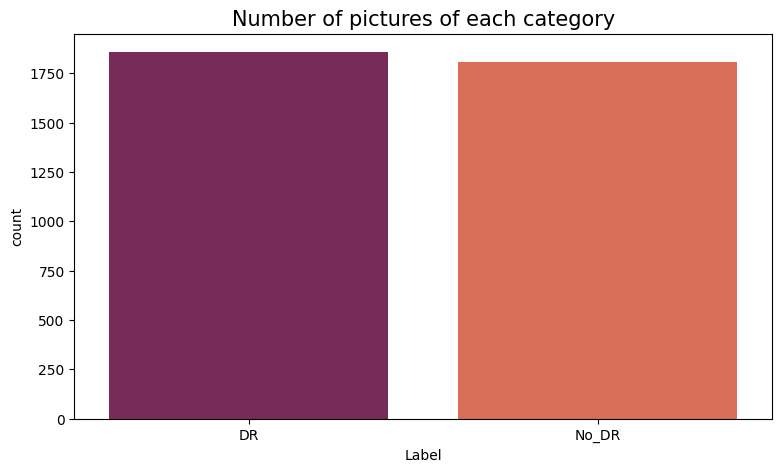

In [54]:
# Display the number of pictures of each category
vc = image_df_red['Label'].value_counts()
plt.figure(figsize=(9,5))
sns.barplot(x = vc.index, y = vc, palette = "rocket")
plt.title("Number of pictures of each category", fontsize = 15)
plt.show()

In [55]:
# Separate in train and test data
train_df, test_df = train_test_split(image_df_red, train_size=0.9, shuffle=True, random_state=1)

In [56]:
# Create the generators
train_generator,test_generator,train_images,val_images,test_images=create_gen()

# Load the pretained model
pretrained_model = tf.keras.applications.MobileNetV2(
    input_shape=(224, 224, 3),
    include_top=False,
    weights='imagenet',
    pooling='avg'
)

pretrained_model.trainable = False


inputs = pretrained_model.input

x = tf.keras.layers.Dense(128, activation='relu')(pretrained_model.output)
x = tf.keras.layers.Dense(128, activation='relu')(x)

outputs = tf.keras.layers.Dense(2, activation='softmax')(x)

model = tf.keras.Model(inputs=inputs, outputs=outputs)

model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

history = model.fit(
    train_images,
    validation_data=val_images,
    batch_size = 32,
    epochs=10,
    callbacks=[
        tf.keras.callbacks.EarlyStopping(
            monitor='val_loss',
            patience=3,
            restore_best_weights=True
        )
    ]
)

Found 2966 validated image filenames belonging to 2 classes.
Found 329 validated image filenames belonging to 2 classes.
Found 367 validated image filenames belonging to 2 classes.
Epoch 1/10
93/93 ━━━━━━━━━━━━━━━━━━━━ 26s 263ms/step - accuracy: 0.8761 - loss: 0.3161 - val_accuracy: 0.9574 - val_loss: 0.1584
Epoch 2/10
93/93 ━━━━━━━━━━━━━━━━━━━━ 25s 261ms/step - accuracy: 0.9539 - loss: 0.1426 - val_accuracy: 0.9483 - val_loss: 0.1409
Epoch 3/10
93/93 ━━━━━━━━━━━━━━━━━━━━ 25s 265ms/step - accuracy: 0.9603 - loss: 0.1065 - val_accuracy: 0.9635 - val_loss: 0.1269
Epoch 4/10
93/93 ━━━━━━━━━━━━━━━━━━━━ 25s 258ms/step - accuracy: 0.9657 - loss: 0.1051 - val_accuracy: 0.9514 - val_loss: 0.1419
Epoch 5/10
93/93 ━━━━━━━━━━━━━━━━━━━━ 24s 253ms/step - accuracy: 0.9700 - loss: 0.0891 - val_accuracy: 0.9574 - val_loss: 0.1294
Epoch 6/10
93/93 ━━━━━━━━━━━━━━━━━━━━ 24s 254ms/step - accuracy: 0.9754 - loss: 0.0822 - val_accuracy: 0.9544 - val_loss: 0.1420


The history saving thread hit an unexpected error (OperationalError('attempt to write a readonly database')).History will not be written to the database.


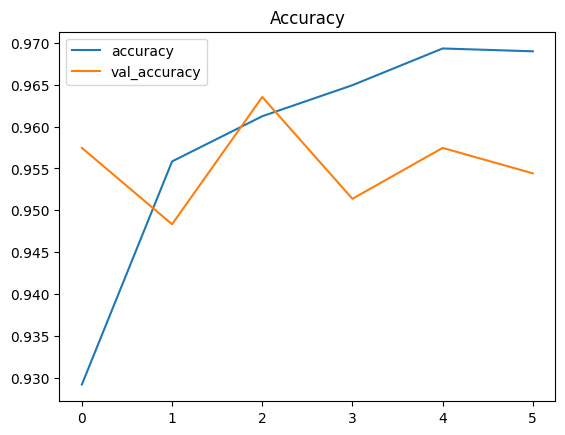

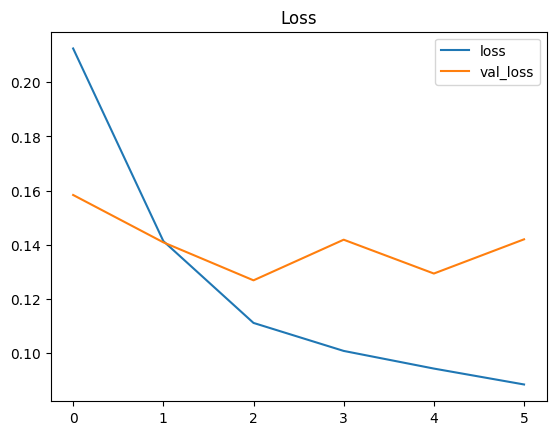

 ## Test Loss: 0.12837

## Accuracy on the test set: 95.37%



12/12 ━━━━━━━━━━━━━━━━━━━━ 3s 248ms/step
The first 5 predictions: ['No_DR', 'DR', 'No_DR', 'No_DR', 'No_DR']
              precision    recall  f1-score   support

          DR       0.95      0.96      0.96       189
       No_DR       0.96      0.94      0.95       178

    accuracy                           0.95       367
   macro avg       0.95      0.95      0.95       367
weighted avg       0.95      0.95      0.95       367



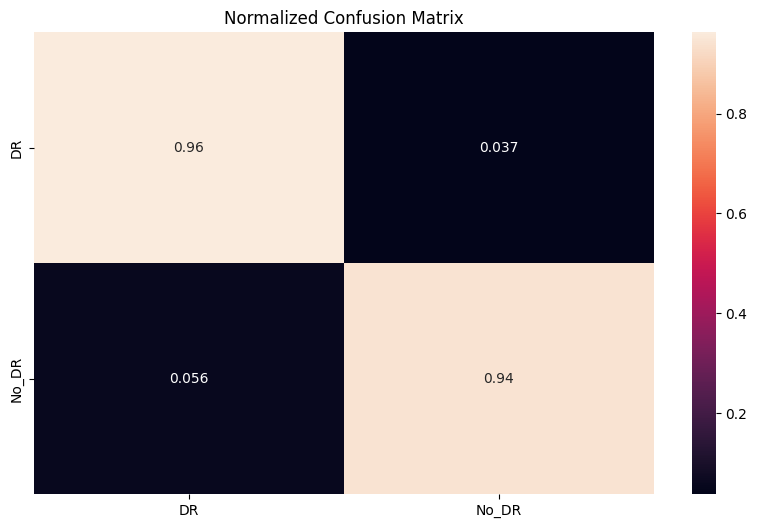

In [59]:
pd.DataFrame(history.history)[['accuracy','val_accuracy']].plot()
plt.title("Accuracy")
plt.show()

pd.DataFrame(history.history)[['loss','val_loss']].plot()
plt.title("Loss")
plt.show()

results = model.evaluate(test_images, verbose=0)

printmd(" ## Test Loss: {:.5f}".format(results[0]))
printmd("## Accuracy on the test set: {:.2f}%".format(results[1] * 100))
print('\n')

# Predict the label of the test_images
pred = model.predict(test_images)
pred = np.argmax(pred,axis=1)

# Map the label
labels = (train_images.class_indices)
labels = dict((v,k) for k,v in labels.items())
pred = [labels[k] for k in pred]

# Display the result
print(f'The first 5 predictions: {pred[:5]}')

from sklearn.metrics import classification_report
y_test = list(test_df.Label)
print(classification_report(y_test, pred))

cf_matrix = confusion_matrix(y_test, pred, normalize='true')
plt.figure(figsize = (10,6))
sns.heatmap(cf_matrix, annot=True, xticklabels = sorted(set(y_test)), yticklabels = sorted(set(y_test)))
plt.title('Normalized Confusion Matrix')
plt.show()